# Mein Model

In [20]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm




# Daten laden
url = "skincare_products.csv"
df = pd.read_csv(url)

# Erste Zeilen anzeigen, um die Daten zu überprüfen
print(df.head())


                                        product_name  \
0  The Ordinary Natural Moisturising Factors + HA...   
1      CeraVe Facial Moisturising Lotion SPF 25 52ml   
2  The Ordinary Hyaluronic Acid 2% + B5 Hydration...   
3          AMELIORATE Transforming Body Lotion 200ml   
4                     CeraVe Moisturising Cream 454g   

                                         product_url product_type  \
0  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   
1  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser   
2  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser   
3  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser   
4  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser   

                                         ingredients   price  
0  Aqua (Water), Caprylic/Capric Triglyceride, Ce...   £5.20  
1  Aqua/Water, Homosalate, Glycerin, Octocrylene,...  £13.00  
2  Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...   £6.2

In [21]:
#Inspect the types of products
display(df['product_type'].value_counts())

product_type
Mask           124
Body Wash      123
Moisturiser    115
Cleanser       115
Serum          113
Eye Care       100
Mist            80
Oil             76
Toner           73
Balm            61
Exfoliator      57
Bath Salts      36
Bath Oil        33
Peel            32
Name: count, dtype: int64

In [22]:
#Check for missing Data 

missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]

print(missing_values)

Series([], dtype: int64)


In [23]:
df.describe()

,product_name,product_url,product_type,ingredients,price
count,1138,1138,1138,1138,1138
unique,1138,1126,14,1090,290
top,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/lancome-advanced...,Mask,"Aqua / Water, Bifida Ferment Lysate, Glycerin,...",£22.00
freq,1,4,124,4,33


In [24]:
# Funktion zur Vorverarbeitung der Inhaltsstoffe
def preprocess_ingredients(text):
    text = text.lower()  # In Kleinbuchstaben umwandeln
    text = re.sub(r'[^a-z,]', '', text)  # Nicht-Buchstaben entfernen, außer Kommas
    ingredients = text.split(",")  # Bei Kommas trennen
    ingredients = [ingredient.strip() for ingredient in ingredients]  # Leerzeichen entfernen
    return ingredients

df['processed_ingredients'] = df['ingredients'].apply(preprocess_ingredients)
df['ingredient_text'] = df['processed_ingredients'].apply(lambda x: ', '.join(x))

Modell aufrufen und Brechnung der Embeddings und Cosine Similarity

In [25]:
# Modell laden (aus tokens_and_embeddings.ipynb)
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

# Funktion zur Berechnung der Embeddings (aus tokens_and_embeddings.ipynb)
def get_embeddings(text):
    return model.encode(text, show_progress_bar=False)

df['embeddings'] = df['ingredient_text'].apply(get_embeddings)

# Cosine Similarity berechnen (aus tokens_and_embeddings.ipynb)
embeddings = np.stack(df['embeddings'].values)
cosine_sim = cosine_similarity(embeddings)

c:\Users\goern_y\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Empfehlung ohne Filter

In [42]:
# Erweiterte Empfehlungsfunktion ohne Filter
def recommend_products_no_filter(product_name, df, cosine_sim, top_k=10):
    try:
        idx = df[df['product_name'] == product_name].index[0]
    except IndexError:
        return "Produktname nicht gefunden."

    # Ähnlichkeitswerte berechnen und sortieren
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Empfohlene Produkte zurückgeben
    recommended_indices = [i[0] for i in sim_scores if i[0] != idx][:top_k]
    recommended_cosine_similarities = [i[1] for i in sim_scores if i[0] != idx][:top_k]

    recommended_products = df.loc[recommended_indices, ['product_name', 'product_url', 'product_type', 'price']]
    recommended_products['cosine_similarity'] = recommended_cosine_similarities

    return recommended_products

# Test der erweiterten Empfehlungsfunktion ohne Filter
recommendations_no_filter = recommend_products_no_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)

# Ausgabe formatieren
pd.set_option('display.max_rows', None)  # Zeilenanzeige erweitern
pd.set_option('display.max_columns', None)  # Spaltenanzeige erweitern
pd.set_option('display.width', 1000)  # Anzeige auf breite Zeile erweitern
pd.set_option('display.colheader_justify', 'left')  # Spaltenüberschriften linksbündig
pd.set_option('display.precision', 6)  # Dezimalstellen für Genauigkeit

print("Empfehlungen ohne Filter basierend auf Cosine Similarity:")
print(recommendations_no_filter)

Empfehlungen ohne Filter basierend auf Cosine Similarity:
    product_name                                       product_url                                        product_type price    cosine_similarity
7    The Ordinary Natural Moisturizing Factors + HA...  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   £6.80  1.000000         
145                      The Ordinary Amino Acids + B5  https://www.lookfantastic.com/the-ordinary-ami...        Serum   £5.90  0.950139         
702                    CeraVe Hydrating Cleanser 473ml  https://www.lookfantastic.com/cerave-hydrating...     Cleanser  £15.00  0.939645         
704               CeraVe Foaming Facial Cleanser 473ml  https://www.lookfantastic.com/cerave-foaming-f...     Cleanser  £15.00  0.935473         
322  Lumene Nordic Hydra [Lähde] Arctic Spring Wate...  https://www.lookfantastic.com/lumene-nordic-hy...         Mist  £12.00  0.934815         
355    Zelens PROVITAMIN D Fortifying Facial Mist 50ml  https://ww

Empfehlungsfunktion mit Produkttyp-Filter

In [43]:
# Empfehlungsfunktion mit Produkttyp-Filter
def recommend_products_type_filter(product_name, df, cosine_sim, top_k=30):
    recommendations = recommend_products_no_filter(product_name, df, cosine_sim, top_k * 2)  # Erhöhe top_k, um genügend Kandidaten zu haben
    original_type = df.loc[df['product_name'] == product_name, 'product_type'].values[0]
    filtered_recommendations = recommendations[recommendations['product_type'] == original_type][:top_k]
    return filtered_recommendations

# Test der Empfehlungsfunktion mit Produkttyp-Filter
recommendations_type_filter = recommend_products_type_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)
print("Empfehlungen mit Produkttyp-Filter:")
print(recommendations_type_filter)


Empfehlungen mit Produkttyp-Filter:
    product_name                                       product_url                                        product_type price    cosine_similarity
7    The Ordinary Natural Moisturizing Factors + HA...  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   £6.80  1.000000         
5                     CeraVe Moisturising Lotion 473ml  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser  £15.00  0.930937         
98   Fade Out ADVANCED + Age Protection Even Skin T...  https://www.lookfantastic.com/fade-out-advance...  Moisturiser  £12.99  0.925015         
94   Fade Out ADVANCED Even Skin Tone Day Cream SPF...  https://www.lookfantastic.com/fade-out-advance...  Moisturiser   £9.99  0.915481         
1        CeraVe Facial Moisturising Lotion SPF 25 52ml  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser  £13.00  0.915280         
40           La Roche-Posay Nutritic Intense Rich 50ml  https://www.lookfantastic.com/la

Empfehlungsfunktion mit Preis- und Produkttyp-Filter

In [44]:
# Empfehlungsfunktion mit Preis- und Produkttyp-Filter
def recommend_products_price_and_type_filter(product_name, df, cosine_sim, top_k=30):
    recommendations = recommend_products_no_filter(product_name, df, cosine_sim, top_k * 2)  # Erhöhe top_k, um genügend Kandidaten zu haben
    original_price = float(df.loc[df['product_name'] == product_name, 'price'].values[0].replace('£', ''))
    original_type = df.loc[df['product_name'] == product_name, 'product_type'].values[0]
    filtered_recommendations = recommendations[(recommendations['product_type'] == original_type) & 
                                               (recommendations['price'].str.replace('£', '').astype(float) <= original_price)][:top_k]
    return filtered_recommendations

# Test der Empfehlungsfunktion mit Preis- und Produkttyp-Filter
recommendations_price_and_type_filter = recommend_products_price_and_type_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)
print("Empfehlungen mit Preis- und Produkttyp-Filter:")
print(recommendations_price_and_type_filter)


Empfehlungen mit Preis- und Produkttyp-Filter:
   product_name                         product_url                                        product_type price   cosine_similarity
72  Bulldog Sensitive Moisturiser 100ml  https://www.lookfantastic.com/bulldog-sensitiv...  Moisturiser  £4.50  0.90509          


## Visualisierung: 

Visualisierung Cosine Similarty 

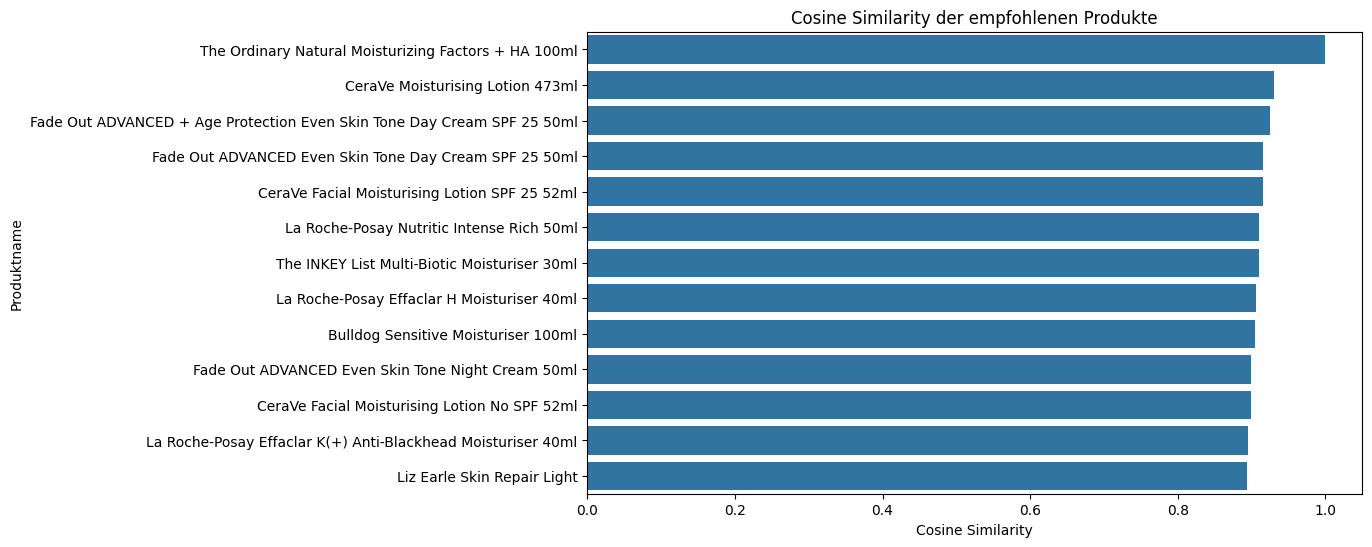

In [45]:
# Funktion zur Visualisierung der Cosine Similarity der empfohlenen Produkte
def plot_cosine_similarity(recommended_products):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cosine_similarity', y='product_name', data=recommended_products)
    plt.title('Cosine Similarity der empfohlenen Produkte')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Produktname')
    plt.show()

# Beispielaufruf der Visualisierungsfunktion
plot_cosine_similarity(recommendations_type_filter)





Visualisierung der Embidden: 


2D Visualisierung mit PCA

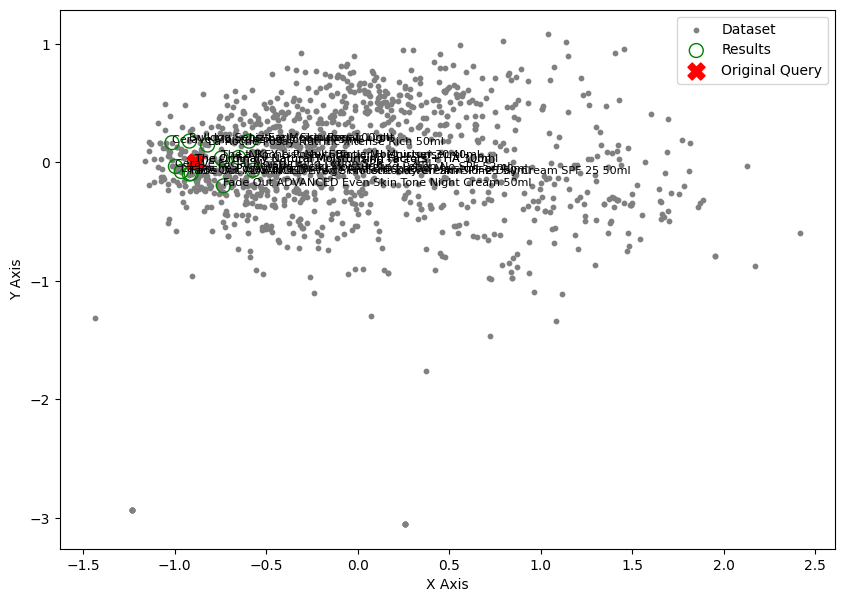

In [46]:
# PCA für 2D-Projektion
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
df['pca_embedding'] = pca_embeddings.tolist()

# 2D-Visualisierung der Embeddings
def plot_2d_embeddings(df, recommended_products, original_product):
    plt.figure(figsize=(10, 7))
    
    # Alle Embeddings
    all_embeddings = np.array(df['pca_embedding'].tolist())
    plt.scatter(all_embeddings[:, 0], all_embeddings[:, 1], s=10, color='gray', label='Dataset')

    # Empfohlene Produkte
    recommended_embeddings = np.array([df.loc[df['product_name'] == name, 'pca_embedding'].values[0] for name in recommended_products['product_name']])
    plt.scatter(recommended_embeddings[:, 0], recommended_embeddings[:, 1], s=100, facecolors='none', edgecolors='g', label='Results')

    # Ursprüngliches Abfrageprodukt
    original_embedding = df.loc[df['product_name'] == original_product, 'pca_embedding'].values[0]
    plt.scatter(original_embedding[0], original_embedding[1], s=150, marker='X', color='r', label='Original Query')

    # Annotations für empfohlene Produkte
    for i, text in enumerate(recommended_products['product_name']):
        plt.annotate(text, (recommended_embeddings[i, 0], recommended_embeddings[i, 1]), fontsize=8)

    plt.annotate(original_product, (original_embedding[0], original_embedding[1]), fontsize=8)
    
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.legend()
    plt.show()

# 2D-Visualisierung
plot_2d_embeddings(df, recommendations_type_filter, "The Ordinary Natural Moisturising Factors + HA 30ml")


3D Visualisierung

KeyError: 'umap_embedding'

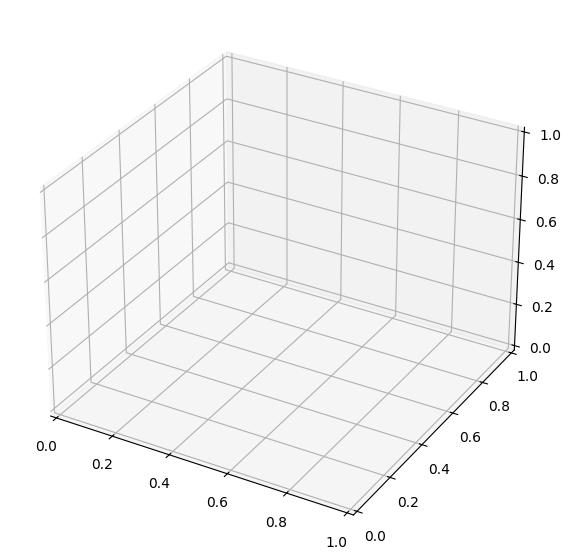

In [47]:
def plot_3d_embeddings(df, recommended_products, original_product):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Alle Embeddings
    all_embeddings = np.array(df['umap_embedding'].tolist())
    ax.scatter(all_embeddings[:, 0], all_embeddings[:, 1], all_embeddings[:, 2], s=10, color='gray', label='Dataset')

    # Empfohlene Produkte
    recommended_embeddings = np.array([df.loc[df['product_name'] == name, 'umap_embedding'].values[0] for name in recommended_products['product_name']])
    ax.scatter(recommended_embeddings[:, 0], recommended_embeddings[:, 1], recommended_embeddings[:, 2], s=100, facecolors='none', edgecolors='g', label='Results')

    # Ursprüngliches Abfrageprodukt
    original_embedding = df.loc[df['product_name'] == original_product, 'umap_embedding'].values[0]
    ax.scatter(original_embedding[0], original_embedding[1], original_embedding[2], s=150, marker='X', color='r', label='Original Query')

    # Annotations für empfohlene Produkte
    for i, text in enumerate(recommended_products['product_name']):
        ax.text(recommended_embeddings[i, 0], recommended_embeddings[i, 1], recommended_embeddings[i, 2], text, fontsize=8)

    ax.text(original_embedding[0], original_embedding[1], original_embedding[2], original_product, fontsize=8)
    
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()
    plt.show()

# Beispielaufruf der 3D-Visualisierung
recommended_products = recommend_products_no_filter("The Ordinary Natural Moisturising Factors + HA 30ml", df, cosine_sim)
plot_3d_embeddings(df, recommended_products, "The Ordinary Natural Moisturising Factors + HA 30ml")


Interpretation der Visualisierungen: 

In [48]:
import numpy as np

def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_and_recommended = set(recommended_at_k) & relevant_items
    return len(relevant_and_recommended) / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_and_recommended = set(recommended_at_k) & relevant_items
    return len(relevant_and_recommended) / len(relevant_items)

def f1_score_at_k(recommended_items, relevant_items, k):
    precision = precision_at_k(recommended_items, relevant_items, k)
    recall = recall_at_k(recommended_items, relevant_items, k)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Beispiel: Relevante Artikel und empfohlene Artikel für einen Benutzer
relevant_items = {'The Ordinary Natural Moisturising Factors + HA 30ml', 'CeraVe Facial Moisturising Lotion SPF 25 52ml'}
recommended_items = recommendations_type_filter['product_name'].tolist()

k = 5
precision = precision_at_k(recommended_items, relevant_items, k)
recall = recall_at_k(recommended_items, relevant_items, k)
f1_score = f1_score_at_k(recommended_items, relevant_items, k)

print(f'Precision@{k}: {precision}')
print(f'Recall@{k}: {recall}')
print(f'F1-Score@{k}: {f1_score}')


Precision@5: 0.2
Recall@5: 0.5
F1-Score@5: 0.28571428571428575


## Interpretation: 

**Precision: 0.20** -> Von den empfohlenen Produkten sind 20% tatsächlich relevant, d.h. 1 in 5 der empfohlenen Produkte sind relevant. Genauigkeit ist  schlecht und kann weiter verbessert werden. 

**Recall: 0.5** -> Das System hat 50% der relevanten Produkte in den Top-5-Empfehlungen gefunden. Dies bedeutet, dass von den insgesamt relevanten Produkten die Hälfte unter den Top-5-Empfehlungen zu finden ist. Dies kann definitiv auch noch verbessert werden. 

**F1-Score: 0.28** -> Ein F1-Score von 0.28 zeigt, dass es noch Verbesserungsbedarf gibt. Um den F1-Score zu verbessern, muss der Precision verbessert werdne. 


## Vergleich Model

Hier habe ich nur die wichtigsten Elemente für den Vergleic hinzugefügt. Ich habe hier den Code eingefügt, um die beiden Modellen einfacher miteinander zu vergleichen. 


Hier der urspüngliche Github-Link: https://github.com/rosagradilla19/skincare-products-recommendation-system

In [51]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE 
from scipy.spatial.distance import cdist

# Load the data
df3 = pd.read_csv("skincare_products.csv")


# Filter for Moisturiser
moisturizers = df3[df3['product_type'] == 'Moisturiser']

# Reset index
moisturizers_subset = moisturizers.reset_index(drop=True)

# Show result
print(moisturizers_subset)


# Initialize dictionary, list, and initial index
ingredient_idx = {}
corpus = []
idx = 0

# For loop for tokenization
for i in range(len(moisturizers_subset)):    
    ingredients = moisturizers_subset['ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens = ingredients_lower.split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
        if ingredient not in ingredient_idx:
            ingredient_idx[ingredient] = idx
            idx += 1

# Get the number of items and tokens 
M = len(moisturizers_subset)
N = len(ingredient_idx)

# Initialize a matrix of zeros
A = np.zeros((M,N))


# Define the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        # Get the index for each ingredient
        idx = ingredient_idx[ingredient]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x


# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i +=1

            
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42)
tsne_features = model.fit_transform(A)

# Make X, Y columns 
moisturizers_subset['X'] = tsne_features[:, 0]
moisturizers_subset['Y'] = tsne_features[:, 1]

# Find similar products -> same product as selected in my model
target = moisturizers_subset[moisturizers_subset['product_name'] == 'The Ordinary Natural Moisturising Factors + HA 30ml']
target

x  = target['X'].values[0]
y = target['Y'].values[0]
print(x, y)


df4 = pd.DataFrame()
df4['point'] = [(x, y) for x,y in zip(moisturizers_subset['X'], moisturizers_subset['Y'])]

df4.head()

point = np.array([[x,y]])

point.shape

moisturizers_subset['distance'] = [cdist(np.array([[x,y]]), np.array([product]), metric='euclidean') for product in df4['point']]

# arrange by descending order
top_matches = moisturizers_subset.sort_values(by=['distance'])
recommendations_tsne = top_matches.head(5)

print("t-SNE Recommendations:")
print(recommendations_tsne)


    product_name                                       product_url                                        product_type ingredients                                        price   
0    The Ordinary Natural Moisturising Factors + HA...  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser  Aqua (Water), Caprylic/Capric Triglyceride, Ce...    £5.20
1        CeraVe Facial Moisturising Lotion SPF 25 52ml  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser  Aqua/Water, Homosalate, Glycerin, Octocrylene,...   £13.00
2    The Ordinary Hyaluronic Acid 2% + B5 Hydration...  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser  Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...    £6.20
3            AMELIORATE Transforming Body Lotion 200ml  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser  Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...   £22.50
4                       CeraVe Moisturising Cream 454g  https://www.lookfantastic.com/cerave-moisturis...

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Berechnung der Metriken
def calculate_metrics(true_labels, recommended_indices, total_items):
    y_true = np.zeros(total_items)
    y_true[true_labels] = 1

    y_pred = np.zeros(total_items)
    y_pred[recommended_indices] = 1

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

# Simulierte wahre Labels für die Bewertung
true_labels = [0]  # Index des tatsächlichen ähnlichen Produkts

# Indizes der empfohlenen Produkte
recommended_indices_tsne = recommendations_tsne.index.tolist()

# Gesamtzahl der Produkte
total_items = len(moisturizers_subset)

# Berechnung der Metriken für t-SNE
precision_tsne, recall_tsne, f1_tsne = calculate_metrics(true_labels, recommended_indices_tsne, total_items)

print("t-SNE Recommendations Metrics:")
print(f"Precision: {precision_tsne:.2f}")
print(f"Recall: {recall_tsne:.2f}")
print(f"F1-Score: {f1_tsne:.2f}")



t-SNE Recommendations Metrics:
Precision: 0.20
Recall: 1.00
F1-Score: 0.33


## Interpretation: 

**Precision: 0.20** -> Von den empfohlenen Produkten sind 20% tatsächlich relevant.

**Recall: 1.00** -> Alle relevanten Produkte wurden vom Empfehlungssystem gefunden. Es werden aber zusätzlich einige irrelevante Produkte empfohlen. 

**F1-Score: 0.33** -> Ein F1-Score von 0.33 zeigt, dass es noch Verbesserungsbedarf gibt. 





# Benchmarking

Hier möchte ich mein Modell mit einem Anderen Modell vergleichen. Ich habe hier ein ähnliches Projekt von Github ausgewählt. 

Hier der Link zum originalen GitHub-Projekt: https://github.com/rosagradilla19/skincare-products-recommendation-system 

Github mit Anpassungen: https://github.com/goernjosi/VergleichModel 

Meine Schritte: 
1) Repository clone 
2) Überprüfen, ob gleiche Produkte verhanden 
3) hatte es leider nicht, daher musste ich mein das repository anpassen auf meinen Datensatz 
4) mit gleichem Produkt testen: The Ordinary Natural Moisturising Factors + HA 30ml
5) Testergebnis vergleichen 
6) top 3 nehmen und von Hand testen, welche Inhaltsstoffe gleich sind 
7) Ergenis vergleichen 
8) Auswertung 


WIE UNTERSCHEIDET SICH UNSERE pROJEKTE? 

eRGEBNISSE MIT vERGLEICH GLEICHES pRODUKT: 


# Vergleich der Ergebnisse: 
**Precision:** Beide Modelle haben die gleiche Precision von 0.20, was zeigt, dass die Genauigkeit der Empfehlungen ähnlich ist und beide Modelle viele irrelevante Empfehlungen machen.

**Recall**: Mein Modell hat einen Recall von 0.5 und das andere Modell einen perfekten Recall von 1.00. Dies bedeutet, dass das andere Modell in der Lage ist, alle relevante Produkte zu finden. Mein schafft nur die Hälfte. 

**F1-Score:** Der F1-Score des anderen Modells ist höher (0.33 vs. 0.286), was zeigt, dass das andere Modell eine bessere Balance zwischen Precision und Recall hat.








In [52]:
#Gleiche Produkte ausgeben von zwei verschiedene Datensätze: 

import pandas as pd

# CSV-Dateien laden
df1 = pd.read_csv('cosmetics.csv')
df2 = pd.read_csv('skincare_products.csv')

# Annahme: 'product_name' ist die Spalte in der ersten CSV und 'Name' ist die Spalte in der zweiten CSV
product_names_1 = df1['Name'].str.lower().str.strip()
product_names_2 = df2['product_name'].str.lower().str.strip()

# Gemeinsamkeiten finden
common_products = set(product_names_1) & set(product_names_2)

print(f"Anzahl der gemeinsamen Produkte: {len(common_products)}")
print("Gemeinsame Produkte:")
for product in common_products:
    print(product)


Anzahl der gemeinsamen Produkte: 0
Gemeinsame Produkte:


#Vergleich Unterschiedliche Modelle gleicher Datensatz:


Vergleich Model: 

Getestet mit: The Ordinary Natural Moisturising Factors + HA 30ml 

Unterschiede Code: 
- Modell und Embeddings: Der erste Code verwendet einen vortrainierten Transformer für die Berechnung der Embeddings, während der zweite Code eine einfache One-Hot-Encoding-Methode verwendet.
- Tokenisierung: Der erste Code übernimmt die Tokenisierung intern im Transformer-Modell, während der zweite Code eine explizite Tokenisierung und Indizierung der Inhaltsstoffe durchführt.
- Dimensionale Reduktion: Der erste Code reduziert nicht explizit die Dimension der Daten, während der zweite Code t-SNE verwendet, um die Daten auf zwei Dimensionen zu reduzieren.
- Empfehlungslogik: Der erste Code enthält eine detaillierte Empfehlungslogik basierend auf Cosine Similarity, während der zweite Code hauptsächlich die Vorbereitung der Daten zur Visualisierung umfasst.



Ergebnise Siehe Screenshot unten 




Vergleichstext: 


Vergleich von Hand: 
Mein Model: 

Anderes Model: 




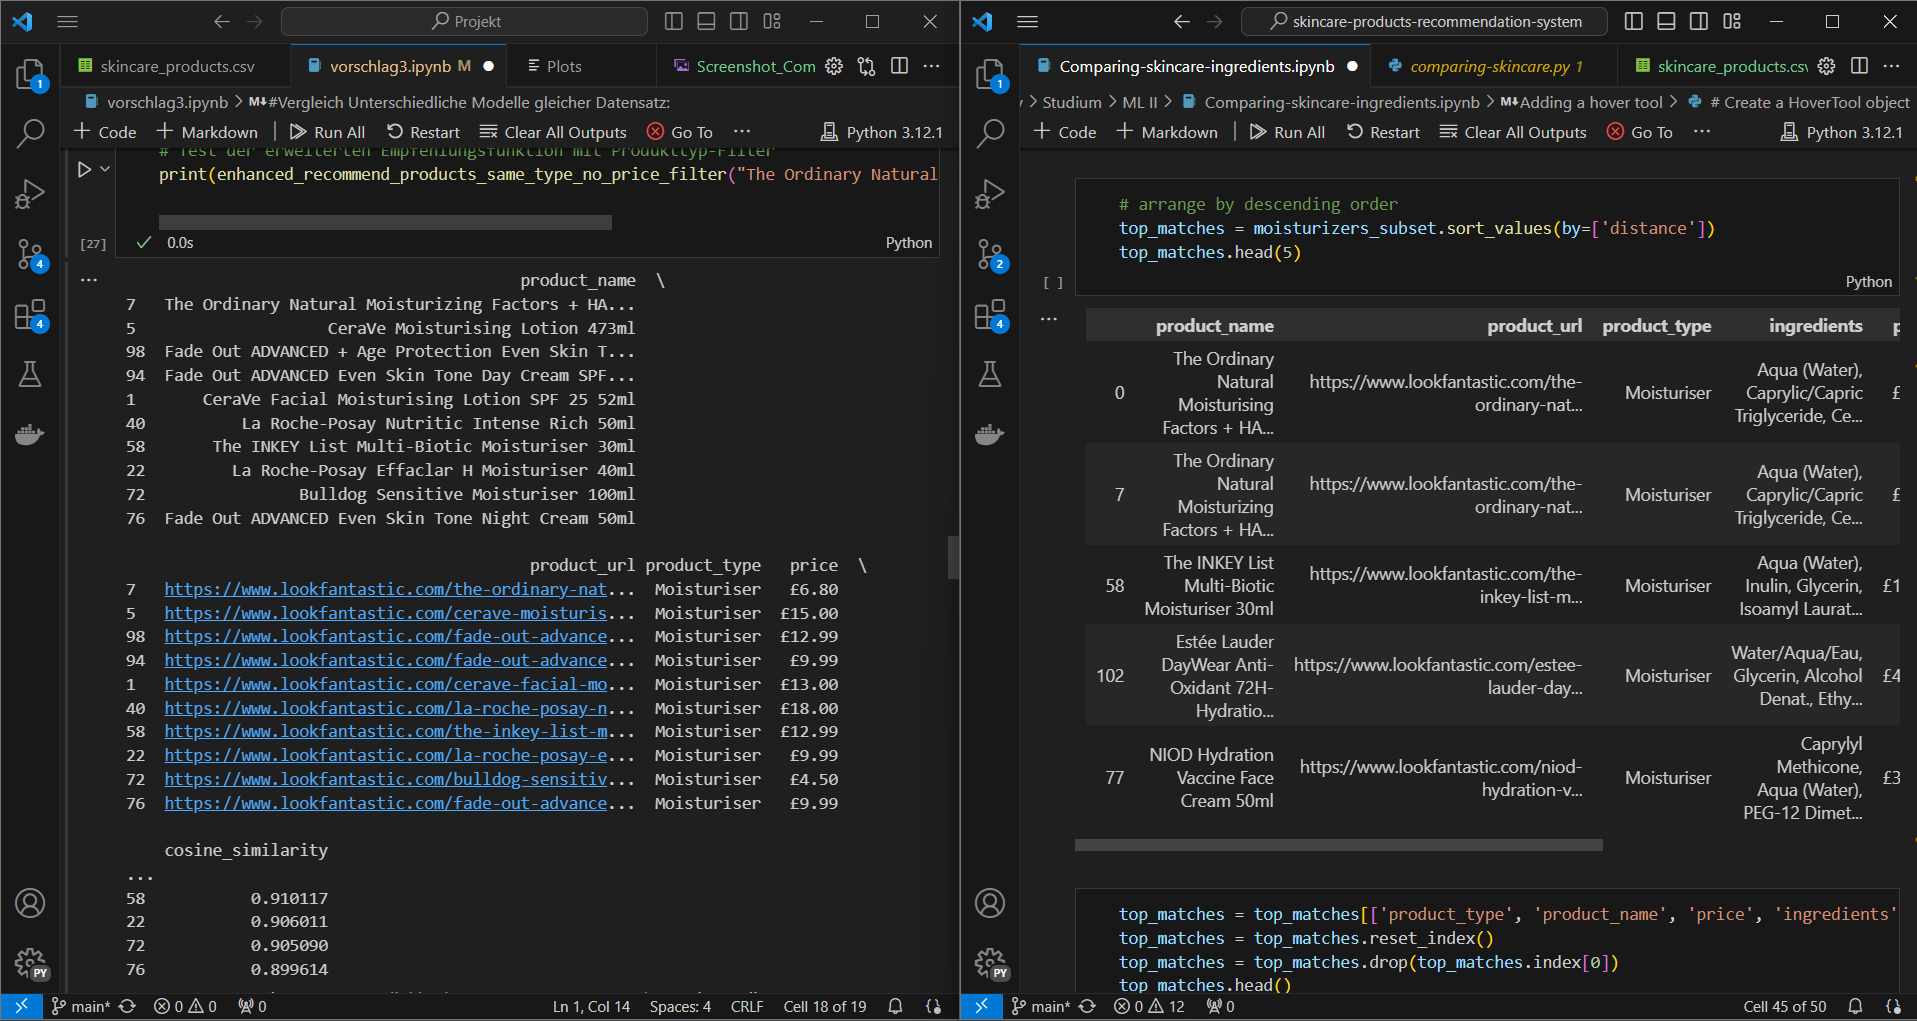

In [ ]:
from IPython.display import Image
Image(filename='Screenshot_Comparison Result.png')

## Vergleich Modell: 



In [55]:
# Ausgabe der beiden Modelle in einer Zelle
print("Cosine Similarity Recommendations:")
print(recommendations_type_filter)
print("\n")
print("t-SNE Recommendations:")
print(recommendations_tsne)

# Vergleich der beiden Modelle
common_recommendations = set(recommendations_type_filter['product_name']).intersection(set(recommendations_tsne['product_name']))
print("\nGemeinsame Empfehlungen:")
print(common_recommendations)

# Anzahl gemeinsamer Empfehlungen
num_common = len(common_recommendations)
print(f"Anzahl gemeinsamer Empfehlungen: {num_common}")

# Anteil gemeinsamer Empfehlungen
total_recommendations = len(recommendations_type_filter)
proportion_common = num_common / total_recommendations
print(f"Anteil gemeinsamer Empfehlungen: {proportion_common:.2f}")


Cosine Similarity Recommendations:
    product_name                                       product_url                                        product_type price    cosine_similarity
7    The Ordinary Natural Moisturizing Factors + HA...  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   £6.80  1.000000         
5                     CeraVe Moisturising Lotion 473ml  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser  £15.00  0.930937         
98   Fade Out ADVANCED + Age Protection Even Skin T...  https://www.lookfantastic.com/fade-out-advance...  Moisturiser  £12.99  0.925015         
94   Fade Out ADVANCED Even Skin Tone Day Cream SPF...  https://www.lookfantastic.com/fade-out-advance...  Moisturiser   £9.99  0.915481         
1        CeraVe Facial Moisturising Lotion SPF 25 52ml  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser  £13.00  0.915280         
40           La Roche-Posay Nutritic Intense Rich 50ml  https://www.lookfantastic.com/la-